In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle
import matplotlib.patches as patches
from ect import ECT, EmbeddedGraph # for figure illustrations we used ect package instead of dect: pip install ect

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
import networkx as nx

plt.rcParams.update({
    'font.size': 14,              # tamaño base de fuente
    'axes.titlesize': 16,         # tamaño del título del gráfico
    'axes.labelsize': 14,         # etiquetas de los ejes
    'xtick.labelsize': 12,        # tamaño de los ticks en el eje x
    'ytick.labelsize': 12,        # tamaño de los ticks en el eje y
    'legend.fontsize': 13,        # tamaño de la leyenda
    'figure.titlesize': 16,       # título general (si usas suptitle)
})

## Euler Characteristic Transform illustration from molecule smile.

In this case, we use as an example the [acetic acid](https://en.wikipedia.org/wiki/Acetic_acid) molecule and its smile, which it is CC(O)=O.

1) Molecule graph

2) Filtration values for x-axis direction

3) Filtration sequence for x-axis direction

4) ECC for this specific direction

5) ECT stacking multiple ECC from different directions



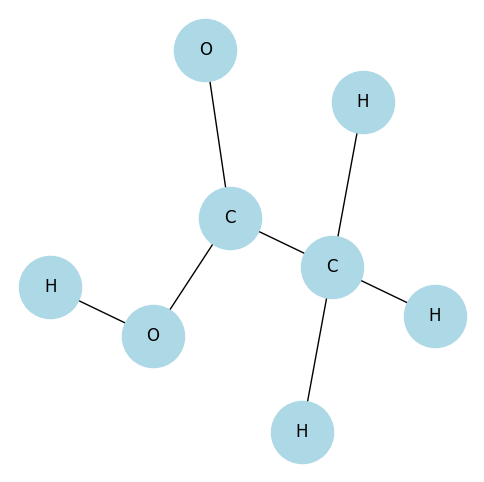

In [2]:
aceticAcidSmile = "CC(O)=O"

# Convert SMILES to RDKit molecule object
mol = Chem.MolFromSmiles(aceticAcidSmile)
mol = Chem.AddHs(mol)  # Add hydrogens if desired

# Compute 2D coordinates (always the same with same seed, for molecule visualization is super nice)
rdDepictor.Compute2DCoords(mol)

# Access node (atom) information
atom_info = {}
for atom in mol.GetAtoms():
    idx = atom.GetIdx()
    atom_info[idx] = {
        "symbol": atom.GetSymbol(),
        "atomic_num": atom.GetAtomicNum(),
        "is_aromatic": atom.GetIsAromatic(),
    }

# In case you want to see the atom information
# print("Atom info:")
# for idx, info in atom_info.items():
#     print(f"Atom {idx}: {info}")

# Build molecule graph with NetworkX
G = nx.Graph()
for atom in mol.GetAtoms():
    idx = atom.GetIdx()
    G.add_node(idx, **atom_info[idx])

for bond in mol.GetBonds():
    start = bond.GetBeginAtomIdx()
    end = bond.GetEndAtomIdx()
    G.add_edge(start, end, bond_type=str(bond.GetBondType()))

# Get 2D coordinates for layout
conf = mol.GetConformer()
pos = {i: (conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y) for i in range(mol.GetNumAtoms())}

# Plot the molecular graph
fig, ax = plt.subplots(1,1,figsize=(6, 6))
nx.draw(G, pos, node_color='lightblue', node_size=2000, font_size=10)
nx.draw_networkx_labels(G, pos, labels={atom.GetIdx(): atom.GetSymbol() for atom in mol.GetAtoms()}, font_color='black')
# plt.title(f"Graph of molecule: {aceticAcidSmile}")
plt.axis('off')
# ax.spines[['right', 'top']].set_visible(False) # if you want to show axis, put previous line on and uncomment this one
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
plt.savefig("figures/IllustrationPaper/moleculeGraph")
plt.show()
plt.close()

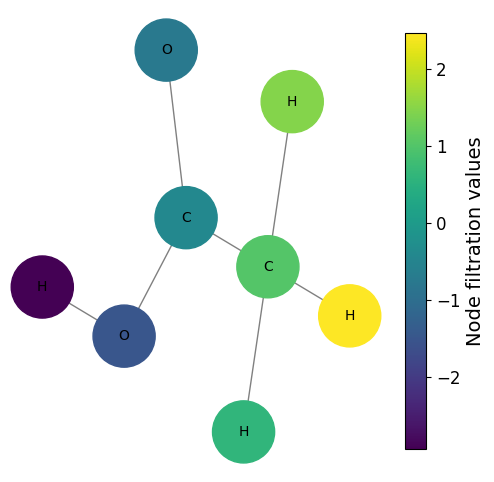

In [3]:
#node filtration values
x_coords = np.array([pos[i][0] for i in G.nodes()])
# Graficar con color de nodo basado en coordenada x
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Escoger un colormap adecuado
cmap = plt.cm.viridis #cool for better node filtration values visualization, viridis for better colorblindness

# Normalizar los valores para el colormap
norm = plt.Normalize(vmin=x_coords.min(), vmax=x_coords.max())
node_colors = cmap(norm(x_coords))

# Dibujar
nx.draw(G, pos, ax=ax, node_color=node_colors, node_size=2000, edge_color='gray')
labels = {i: atom.GetSymbol() for i, atom in enumerate(mol.GetAtoms())}
nx.draw_networkx_labels(G, pos, labels=labels, font_color='black', font_size=10)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Mostrar barra de color (opcional)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.9)
cbar.set_label("Node filtration values")

# Ajustes finales
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.axis('off')
plt.savefig("figures/IllustrationPaper/MoleculeGraphFiltrationValuesExample", dpi=300)
plt.show()
plt.close()

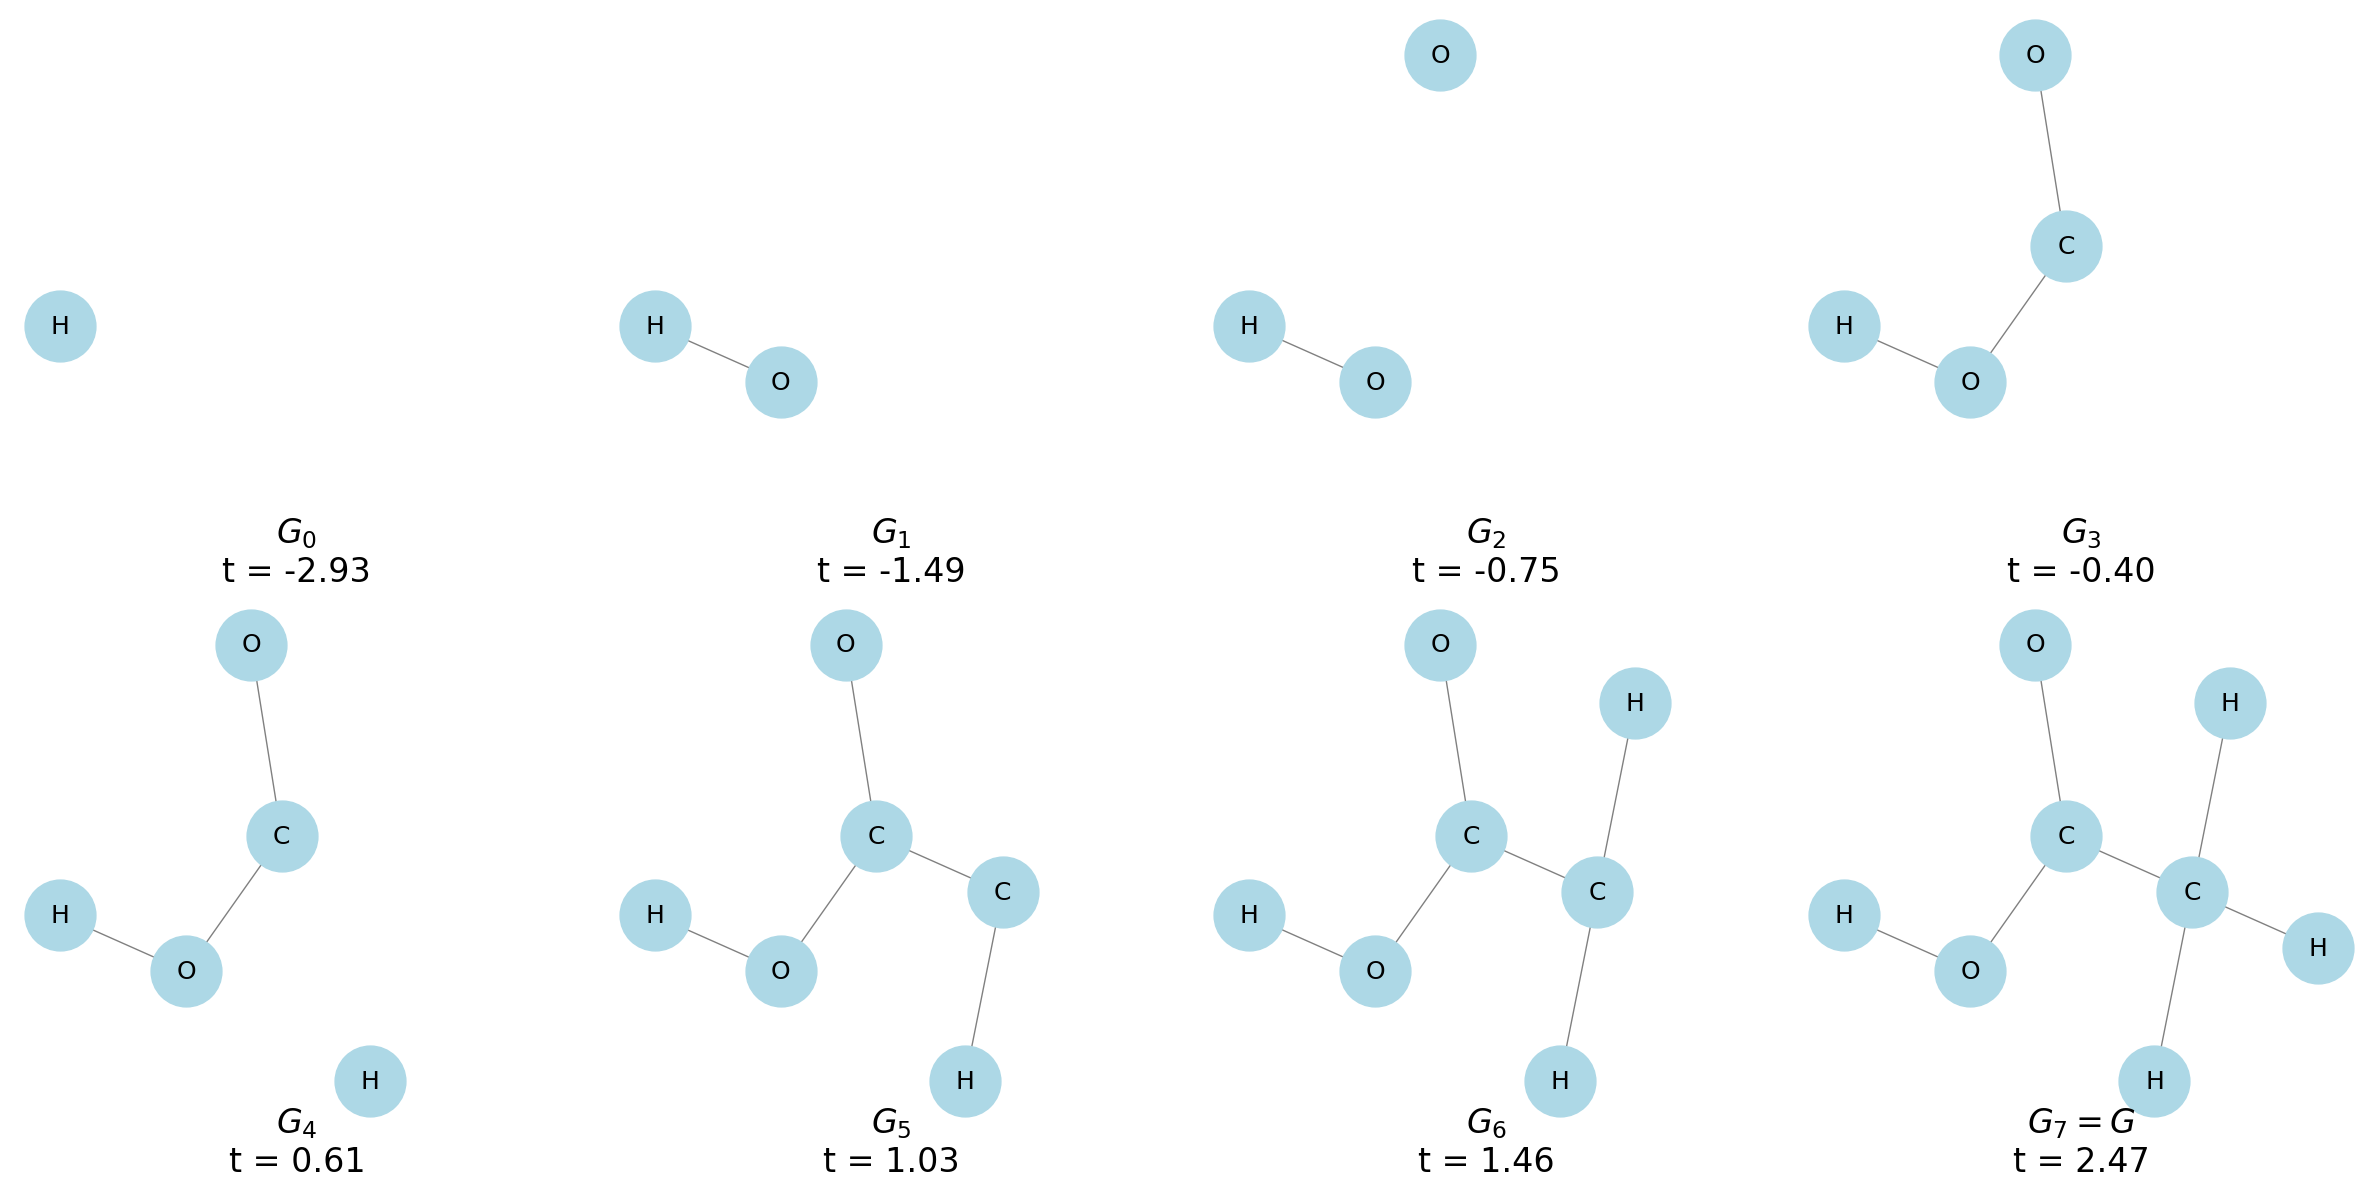

In [4]:
# Usar coordenada x como filtración direccional
node_filtration = {i: pos[i][0] for i in G.nodes()}
filtration_times = sorted(set(node_filtration.values()))

fig, axes = plt.subplots(2, 4, figsize=(6*4, 12))
axes = axes.flatten()

# Dibujar cada paso de la filtración
for i, t in enumerate(filtration_times):
    ax = axes[i]
    # Nodos activos
    active_nodes = [n for n, val in node_filtration.items() if val <= t]
    # Aristas activas
    active_edges = [(u, v) for u, v in G.edges() if u in active_nodes and v in active_nodes]

    subG = G.subgraph(active_nodes)
    active_pos = {n: pos[n] for n in subG.nodes()}
    nx.draw(subG, active_pos, ax=ax, with_labels=False, node_color='lightblue', node_size=2600, edge_color='gray')
    
    for n in subG.nodes():
        x, y = active_pos[n]
        ax.text(x, y, G.nodes[n]["symbol"], fontsize=18, ha='center', va='center', color='black')

    if i == len(node_filtration)-1:
        ax.set_title(f"$G_{i}=G$\nt = {t:.2f}",fontsize=24,y=-0.1)
    else:
        ax.set_title(f"$G_{i}$\nt = {t:.2f}",fontsize=24,y=-0.1)
        
    
    # ax.set_axis_on()
    # ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
# Borrar subplots vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# fig.suptitle("Filtration sequence", fontsize=24)
plt.tight_layout()
plt.savefig("figures/IllustrationPaper/MoleculeFiltrationSequenceAxisX")
# plt.subplots_adjust(top=0.90)
plt.show()
plt.close()

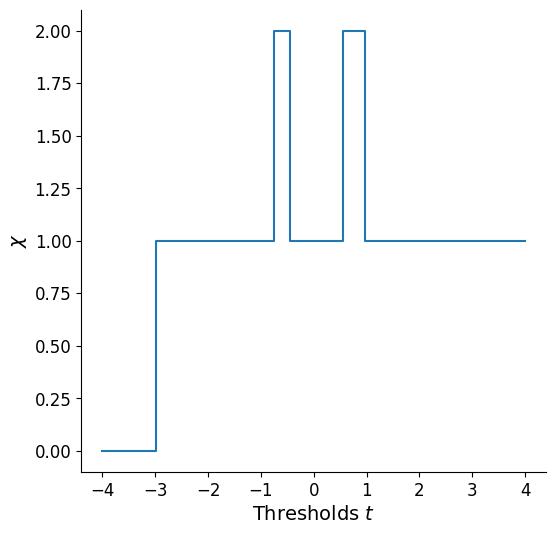

In [5]:
Graphect = EmbeddedGraph()
for nodeKey in pos:
    Graphect.add_node(nodeKey, [pos[nodeKey][0], pos[nodeKey][1]])
for edge in G.edges:
    Graphect.add_edge(edge[0], edge[1])

myect = ECT(num_dirs=10, thresholds=np.linspace(-4,4,80))
ect = myect.calculate(Graphect)

ecc = myect.calculate(Graphect, theta=2*np.pi).squeeze()
directions=myect.directions
thresholds=myect.thresholds

fig, ax = plt.subplots(1,1,figsize=(6, 6))
plt.step(thresholds,ecc)
plt.xlabel("Thresholds $t$")
plt.ylabel("$\chi$")
plt.axis('on')
ax.spines[['right', 'top']].set_visible(False) 
plt.savefig("figures/IllustrationPaper/MoleculeECC.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

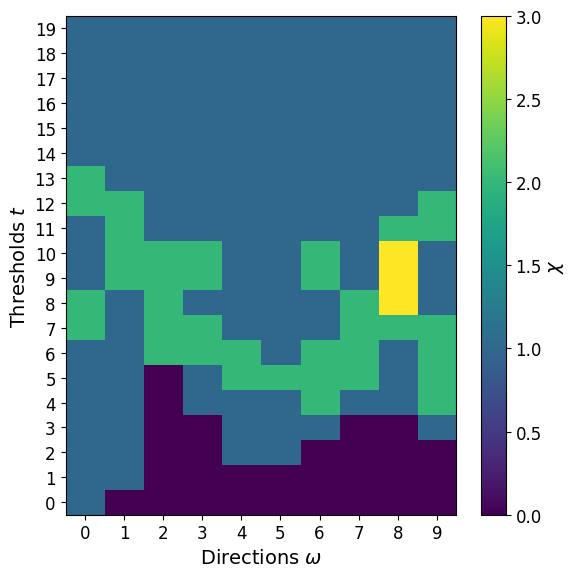

In [6]:
myect = ECT(num_dirs=10, num_thresh=20)
ect = myect.calculate(Graphect)
directions=myect.directions
thresholds=myect.thresholds


plt.figure(figsize=(6, 6))
plt.imshow(ect.transpose(), aspect='auto', cmap='viridis', origin="lower")  # o cualquier colormap
plt.colorbar(label='$\chi$')	

# Etiquetas en columnas: ángulos
plt.yticks(ticks=range(len(thresholds)), labels=np.round(thresholds,2))
plt.yticks(ticks=range(len(thresholds)), labels=np.arange(0,len(thresholds)))
plt.xticks(ticks=range(len(directions)), labels=np.arange(0,len(directions)))
plt.xlabel("Directions $\omega$")
plt.ylabel("Thresholds $t$")
# plt.title("Euler Characteristic Transform Matrix")
plt.tight_layout()
plt.savefig("figures/IllustrationPaper/MoleculeECT2.png", dpi=300, bbox_inches='tight')
plt.show()